In [186]:
# Data Libraries
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option("max_colwidth", None)
# Statistic Libraries
import statsmodels.api as sm
# Machine Learning Libraries
from catboost import CatBoostClassifier
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import SVC, LinearSVC
from sklearn.utils.fixes import loguniform
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix, auc
from sklearn.metrics import precision_recall_curve, roc_curve, make_scorer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from funcsigs import signature
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# Plot Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# cosmetic options
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")
rc = {"figure.figsize": (6.4, 4.8),
      "figure.dpi": 300,
      "axes.titlesize": "large",
      "axes.titleweight": "bold",
      "axes.titlepad": 12,
      "axes.titlelocation": "left"}
sns.set_theme(context="notebook", style="darkgrid", color_codes=True, rc=rc)

In [7]:
def import_dataset(filename):
    """
    Import the dataset from the path.

    Parameters
    ----------
        filename : str
            filename with path

    Returns
    -------
        data : DataFrame

    Examples
    --------
        bank_mkt = import_dataset("../data/BankMarketing.csv")
    """
    bank_mkt = pd.read_csv(filename,
                           na_values=["unknown", "nonexistent"],
                           true_values=["yes", "success"],
                           false_values=["no", "failure"])
    # Treat pdays = 999 as missing values
    bank_mkt["pdays"] = bank_mkt["pdays"].replace(999, pd.NA)
    # `month` will be encoded to the corresponding number, e.g. "mar" -> 3
    month_map = {"mar": 3,
                 "apr": 4,
                 "may": 5,
                 "jun": 6,
                 "jul": 7,
                 "aug": 8,
                 "sep": 9,
                 "oct": 10,
                 "nov": 11,
                 "dec": 12}
    bank_mkt["month"] = bank_mkt["month"].replace(month_map)
    # `day_of_week` will be encoded to the corresponding number, e.g. "wed" -> 3
    dow_map = {"mon":1,
               "tue":2,
               "wed":3,
               "thu":4,
               "fri":5}
    bank_mkt["day_of_week"] = bank_mkt["day_of_week"].replace(dow_map)
    # Convert types, "Int64" is nullable integer data type in pandas
    bank_mkt = bank_mkt.astype(dtype={"age": "Int64",
                                      "job": "category",
                                      "marital": "category",
                                      "education": "category",
                                      "default": "boolean",
                                      "housing": "boolean",
                                      "loan": "boolean",
                                      "contact": "category",
                                      "month": "Int64",
                                      "day_of_week": "Int64",
                                      "duration": "Int64",
                                      "campaign": "Int64",
                                      "pdays": "Int64",
                                      "previous": "Int64",
                                      "poutcome": "boolean",
                                      "y": "boolean"})
    # Drop 12 duplicated rows
    bank_mkt = bank_mkt.drop_duplicates().reset_index(drop=True)
    # reorder ordinal categorical data
    bank_mkt["education"] = bank_mkt["education"].cat.reorder_categories(["illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"], ordered=True)
    return bank_mkt

In [2]:
def split_dataset(data, preprocessor=None, random_state=42):
    """
    Split dataset into train, test and validation sets using preprocessor.
    Because the random state of validation set is not specified, the validation set will be different each time when the function is called.

    Parameters
    ----------
        data : DataFrame

        preprocessor : Pipeline
        
        random_state : int

    Returns
    -------
        datasets : tuple

    Examples
    --------
        from sklearn.preprocessing import OrdinalEncoder
        data = import_dataset("../data/BankMarketing.csv").interpolate(method="pad").loc[:, ["job", "education", "y"]]
        # To unpack all train, test, and validation sets 
        X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack train and test sets.
        X_train, y_train, X_test, y_test, *other_sets = split_dataset(data, OrdinalEncoder())
        # To unpack test and validation set
        *other_sets, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack only train set.
        X_train, y_train, *other_sets = split_dataset(data, OneHotEncoder())
    """
    train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    for train_index, test_index in train_test_split.split(data.drop("y", axis=1), data["y"]):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]

    X_train = train_set.drop(["duration", "y"], axis=1)
    y_train = train_set["y"].astype("int").to_numpy()
    X_test = test_set.drop(["duration", "y"], axis=1)
    y_test = test_set["y"].astype("int").to_numpy()

    train_validate_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    for ttrain_index, validate_index in train_validate_split.split(X_train, y_train):
        ttrain_set = train_set.iloc[ttrain_index]
        validate_set = train_set.iloc[validate_index]
    
    X_ttrain = ttrain_set.drop(["duration", "y"], axis=1)
    y_ttrain = ttrain_set["y"].astype("int").to_numpy()
    X_validate = validate_set.drop(["duration", "y"], axis=1)
    y_validate = validate_set["y"].astype("int").to_numpy()

    if preprocessor != None:
        X_train = preprocessor.fit_transform(X_train, y_train)
        X_test = preprocessor.transform(X_test)
        X_ttrain = preprocessor.fit_transform(X_ttrain, y_ttrain)
        X_validate = preprocessor.transform(X_validate)

    return (X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate)

In [3]:
def benchmark(data, preprocessor=None, clf=None):
    """
    Benchmark preprocessor and clf's performance on train, validation and test sets. 
    All the data transformation should be handled by preprocessor and estimation should be handled by clf.
    
    Parameters
    ----------
        data : DataFrame
        
        preprocessor : Pipeline, default = None
        
        clf : estimator, default = None
        
    """
    X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, preprocessor)
    X_sets = [X_ttrain, X_validate, X_test]
    y_sets = [y_ttrain, y_validate, y_test]
    
    metric_names = ["TNR", "TPR", "bACC", "ROC", "REC", "PRE", "AP"]
    set_names = ["Train", "Validate", "Test"]
    metric_df = pd.DataFrame(index=metric_names, columns=set_names)
            
    try:
        clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
    except (ValueError, TypeError):
        clf.fit(X_ttrain, y_ttrain)
        
    for name, X, y in zip(set_names, X_sets, y_sets):
        # Re-fit model on train set before test set evaluation except CatBoost
        if name == "Test" and not isinstance(clf, CatBoostClassifier):
            clf.fit(X_train, y_train)
        y_pred = clf.predict(X)

        try:
            y_score = clf.decision_function(X)
        except AttributeError:
            y_score = clf.predict_proba(X)[:, 1]
            
        metrics = [recall_score(y, y_pred, pos_label=0),
                   recall_score(y, y_pred),
                   balanced_accuracy_score(y, y_pred),
                   roc_auc_score(y, y_score),
                   recall_score(y, y_pred),
                   precision_score(y, y_pred),
                   average_precision_score(y, y_score)]
        metric_df[name] = metrics
        
    return metric_df

In [98]:
def dftransform(X,
                drop=None,
                cut=None,
                gen=None,
                cyclic=None,
                target=None,
                fillna=True,
                to_float=False):
    """
    Encode, transform, and generate categorical data in the dataframe.
    
    Parameters
    ----------
        X : DataFrame
        
        drop : list, default = None
        
        gen : list, default = None
        
        cut : list, default = None
        
        external : list, default = None
        
        cyclic : list, default = None

        fillna : boolean, default = True
        
        to_float : boolean, default = False
    
    Returns
    -------
        X : DataFrame

    Examples
    --------
    bank_mkt = import_dataset("../data/BankMarketing.csv")
    X = dftransform(bank_mkt)
    """
    X = X.copy()
    
    if gen != None:
        if "year" in gen or "days" in gen:
            X.loc[X.index < 27682, "year"] = 2008
            X.loc[(27682<=X.index) & (X.index<39118), "year"] = 2009
            X.loc[39118<=X.index, "year"] = 2010
            X["year"] = X["year"].astype("int")
        if "days" in gen:
            X["date"] = pd.to_datetime(X[["month", "year"]].assign(day=1))
            X["lehman"] = pd.to_datetime("2008-09-15")
            X["days"] = X["date"] -  X["lehman"]
            X["days"] = X["days"].dt.days
            X = X.drop(["lehman", "year", "date"], axis=1)
        if "has_previous" in gen:
            X["has_previous"] = X["previous"] > 0
        if "has_default" in gen:
            X["has_default"] = X["default"].notna()
        if "has_marital" in gen:
            X["has_marital"] = X["marital"].notna()

    if cut != None:
        if "pdays" in cut:
            # Cut pdays into categories
            X["pdays"] = pd.cut(X["pdays"], [0, 3, 5, 10, 15, 30, 1000], labels=[3, 5, 10, 15, 30, 1000], include_lowest=True).astype("Int64")
    
    if cyclic != None:
        if "month" in cyclic:
            X['month_sin'] = np.sin(2 * np.pi * X["month"]/12)
            X['month_cos'] = np.cos(2 * np.pi * X["month"]/12)
            X = X.drop("month", axis=1)
        if "day_of_week" in cyclic:
            X['day_sin'] = np.sin(2 * np.pi * X["day_of_week"]/5)
            X['day_cos'] = np.cos(2 * np.pi * X["day_of_week"]/5)
            X = X.drop("day_of_week", axis=1)
            
    # Transform target encoded feature as str
    if target != None:
        X[target] = X[target].astype("str")

    # Other categorical features will be coded as its order in pandas categorical index
    X = X.apply(lambda x: x.cat.codes if pd.api.types.is_categorical_dtype(x) else (x.astype("Int64") if pd.api.types.is_bool_dtype(x) else x))
    
    if fillna:
        # Clients who have been contacted but do not have pdays record should be encoded as 999
        # Clients who have not been contacted should be encoded as -999 
        X.loc[X["pdays"].isna() & X["poutcome"].notna(), "pdays"] = 999
        X["pdays"] = X["pdays"].fillna(-999)
        # Fill other missing values as -1
        X = X.fillna(-1)
    else:
        X = X.astype("float")
    
    if drop != None:
        # Drop features
        X = X.drop(drop, axis=1)
    
    if to_float:
        X = X.astype("float")
    
    return X

# Bank Marketing Data Analytics

# Exploratory Data Analysis

Exploratory Data Analysis is a process to explore the dataset with no assumptions or hypothesis. The objective is to give us enough insights for the future work.

In [41]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [42]:
bank_mkt["y"].count()

41176

In [43]:
bank_mkt["y"].sum()/bank_mkt["y"].count()

0.11266271614532737

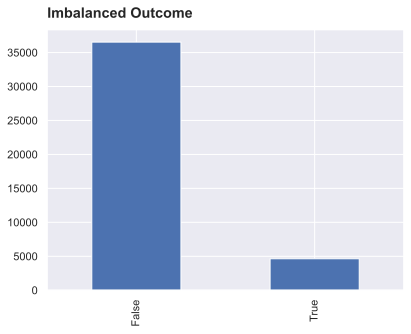

In [44]:
y_count = bank_mkt["y"].value_counts().plot(kind = "bar", title="Imbalanced Outcome")

Using `info()` we can see that most of features concerning the client are categorical/boolean type. And some fields such as `job`, `marital`, `education`, etc. are missing.

In [45]:
bank_mkt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41176 non-null  Int64   
 1   job             40846 non-null  category
 2   marital         41096 non-null  category
 3   education       39446 non-null  category
 4   default         32580 non-null  boolean 
 5   housing         40186 non-null  boolean 
 6   loan            40186 non-null  boolean 
 7   contact         41176 non-null  category
 8   month           41176 non-null  Int64   
 9   day_of_week     41176 non-null  Int64   
 10  duration        41176 non-null  Int64   
 11  campaign        41176 non-null  Int64   
 12  pdays           1515 non-null   Int64   
 13  previous        41176 non-null  Int64   
 14  poutcome        5625 non-null   boolean 
 15  emp.var.rate    41176 non-null  float64 
 16  cons.price.idx  41176 non-null  float64 
 17  cons.conf.id

## Time-ordered Data

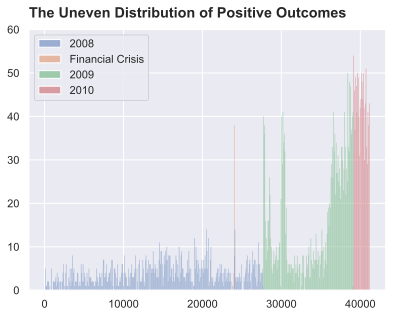

In [46]:
bank_year = bank_mkt.copy()
bank_year["year"]=2008
bank_year.loc[27682:, "year"] = 2009
bank_year.loc[39118:, "year"] = 2010
p = bank_year[bank_year.y == True].reset_index()
p.loc[(p.month == 10) & (p.year==2008), "year"] = "Financial Crisis"
ax = sns.histplot(data=p, x="index", stat="count", hue="year", bins=500, palette="deep", legend=True)
ax.get_legend().set_title("")
ax.set_ylim(0,60)
ax.set(title="The Uneven Distribution of Positive Outcomes", xlabel="", ylabel="");

Oct 2008 is a special case possibly due to the financial crisis.

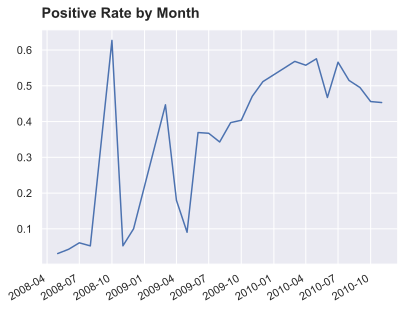

In [47]:
bank_year["date"] = pd.to_datetime(bank_year[["month", "year"]].assign(day=1))
bank_year["y"] = bank_year["y"].astype("int")
bank_year[["date", "y"]].groupby("date").mean().plot.line(xlabel="", ylabel="", title="Positive Rate by Month", legend=False);

### Missing values

By checking the number of missing values, we can see nearly all client do not have `pdays` and `poutcome`. 20% of the clients do not have information of `default`.

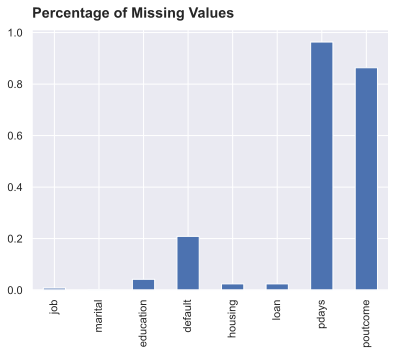

In [48]:
na = bank_mkt.isna().sum()
na_nonzero = na[na != 0]
na_perc = na_nonzero/bank_mkt.y.count()
na_bar = na_perc.plot.bar(title="Percentage of Missing Values")

### Client Data

Let's start with client data. Most of the clients's age are between 32 to 47 while there are some outlier cases beyond 70. This may imply that we should choose standardization for scaling since it's more tolerant for outliers. From the graph below we can see that the age distribution in the true outcome group has lower median age but is more skewed toward an slightly older population.

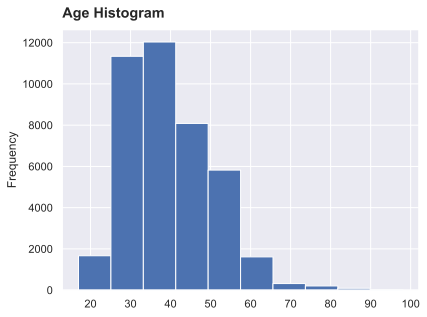

In [52]:
bank_mkt["age"].plot.hist(title="Age Histogram");

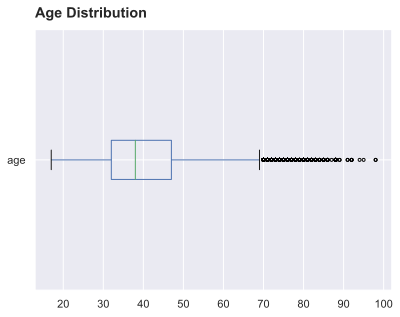

In [53]:
bank_mkt["age"].plot.box(vert=False, sym=".", title="Age Distribution");

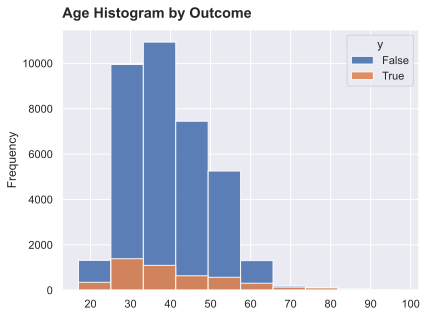

In [54]:
age_y = bank_mkt[["age", "y"]].pivot(columns="y", values="age")
age_y.plot.hist(alpha=0.9, legend=True, title="Age Histogram by Outcome");

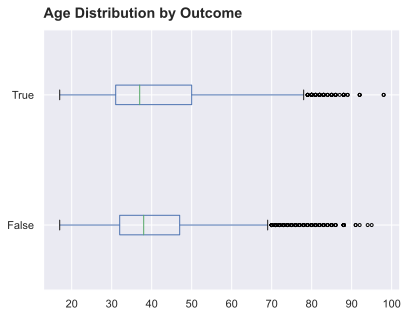

In [55]:
age_y.plot.box(vert=False, sym=".", title="Age Distribution by Outcome");

In [57]:
def cat_outcome(df, feature):
    df = df.copy()
    if pd.api.types.is_categorical_dtype(df[feature]) and df[feature].isna().sum() > 0:
        df[feature] = df[feature].cat.add_categories("unknown")
        df[feature] = df[feature].fillna("unknown")
    title = feature.title().replace("_", " ").replace("Of", "of")
    f, axs = plt.subplots(1, 2, figsize=(8.6, 4.8), sharey=True, gridspec_kw=dict(wspace=0.04, width_ratios=[5, 2]))
    ax0 = df["y"].groupby(df[feature], dropna=False).value_counts(normalize=True).unstack().plot.barh(xlabel="", legend=False, stacked=True, ax=axs[0], title=f"Outcome Percentage and Total by {title}")
    ax1 = df["y"].groupby(df[feature], dropna=False).value_counts().unstack().plot.barh(xlabel="", legend=False, stacked=True, ax=axs[1])

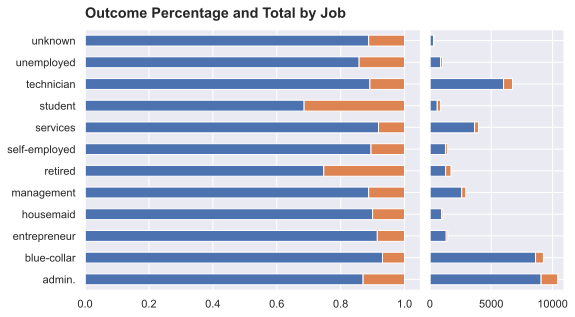

In [58]:
job_outcome = cat_outcome(bank_mkt, "job")

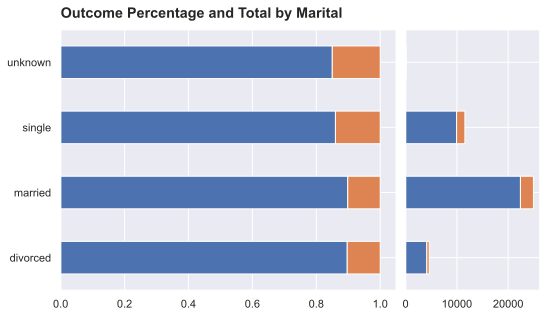

In [59]:
marital_outcome = cat_outcome(bank_mkt, "marital")

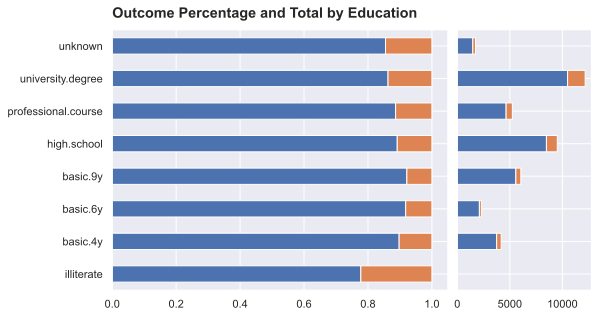

In [60]:
education_outcome = cat_outcome(bank_mkt, "education")

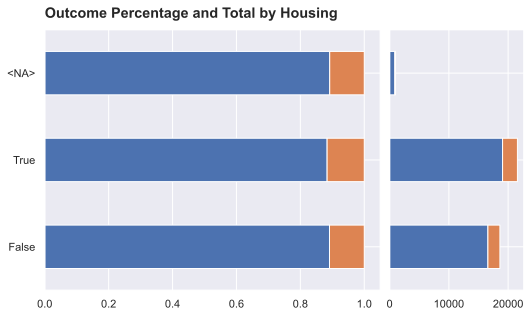

In [62]:
housing_outcome = cat_outcome(bank_mkt, "housing")

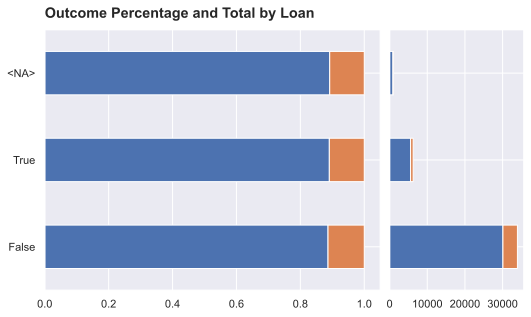

In [63]:
loan_outcome = cat_outcome(bank_mkt, "loan")

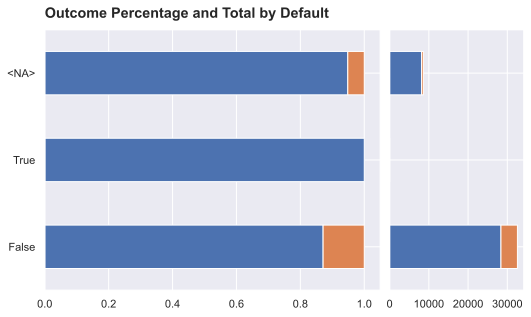

In [61]:
default_outcome = cat_outcome(bank_mkt, "default")

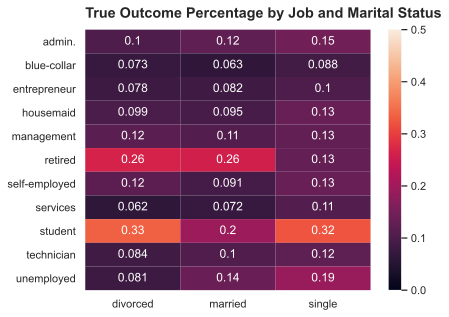

In [65]:
job_marital_total = bank_mkt[["job", "marital", "y"]].groupby(["job", "marital"]).count().y.unstack()
job_marital_true = bank_mkt[["job", "marital", "y"]].groupby(["job", "marital"]).sum().y.unstack()
job_marital_rate = job_marital_true / job_marital_total
job_marital_rate = job_marital_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
sns.heatmap(data=job_marital_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Job and Marital Status");

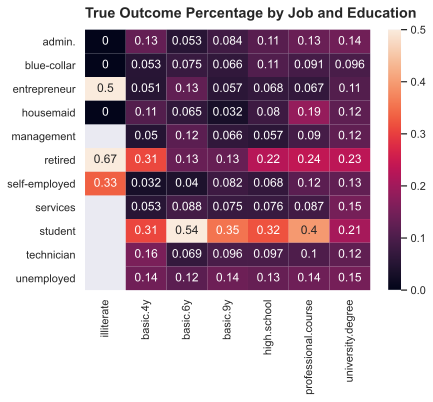

In [66]:
job_education_total = bank_mkt[["job", "education", "y"]].groupby(["job", "education"]).count().y.unstack()
job_education_true = bank_mkt[["job", "education", "y"]].groupby(["job", "education"]).sum().y.unstack()
job_education_rate = job_education_true / job_education_total
job_education_rate = job_education_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
sns.heatmap(data=job_education_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Job and Education");

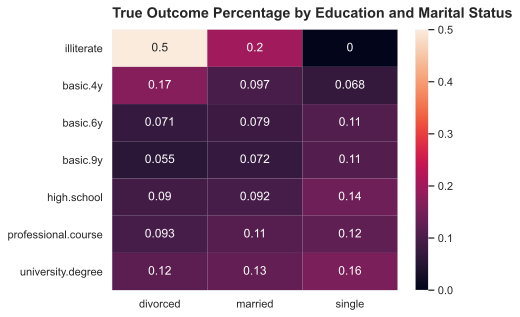

In [67]:
education_marital_total = bank_mkt[["education", "marital", "y"]].groupby(["education", "marital"]).count().y.unstack()
education_marital_true = bank_mkt[["education", "marital", "y"]].groupby(["education", "marital"]).sum().y.unstack()
education_marital_rate = education_marital_true / education_marital_total
education_marital_rate = education_marital_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
sns.heatmap(data=education_marital_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Education and Marital Status");

### Current Campaign

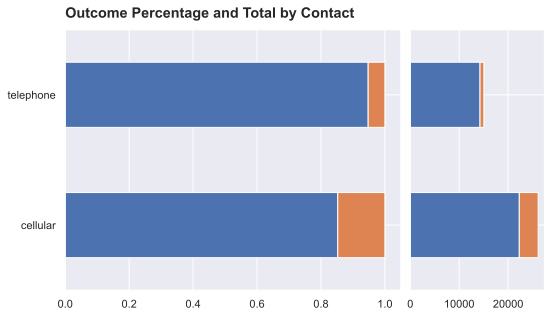

In [79]:
cat_outcome(bank_mkt, "contact")

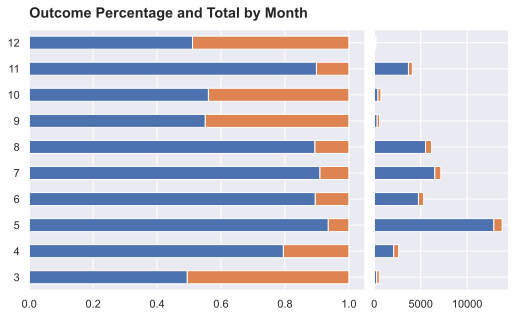

In [78]:
cat_outcome(bank_mkt, "month")

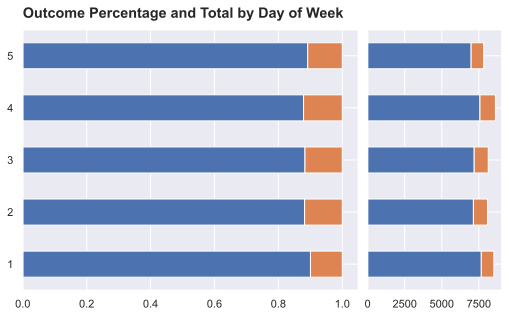

In [77]:
cat_outcome(bank_mkt, "day_of_week")

### Previous Campaign

We can plot the dirstribution of `pdays` and `previous`. As we can see, most of the client with `pdays` has been contacted 3 to 6 days before and peaked at 3 and 6 days.

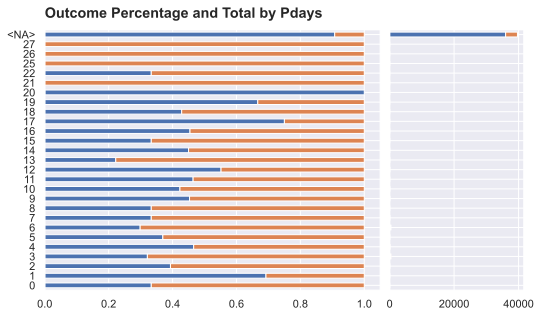

In [80]:
cat_outcome(bank_mkt, "pdays")

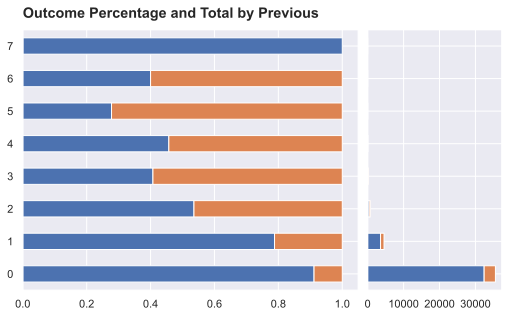

In [81]:
cat_outcome(bank_mkt, "previous")

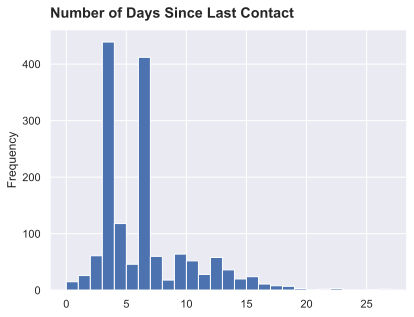

In [85]:
bank_mkt["pdays"].plot.hist(bins=27, title="Number of Days Since Last Contact");

Most of the client has never been contacted before.

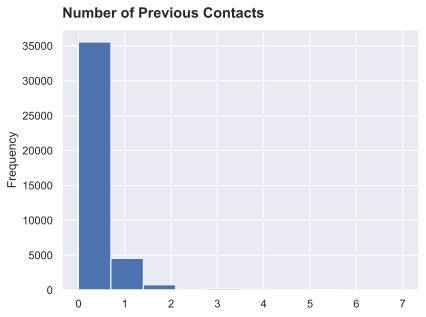

In [84]:
bank_mkt["previous"].plot.hist(title="Number of Previous Contacts");

If `pdays` is missing value, that means that the client was not previously contacted and therefore should not have `poutcome`. But `poutcome` column has less missing values than `pdays`. 

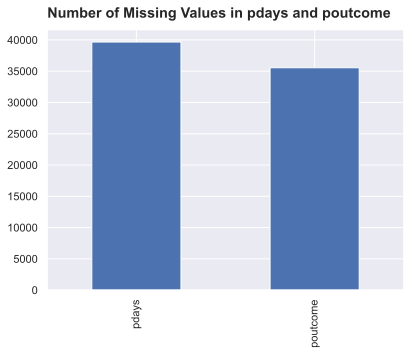

In [83]:
previous_na = bank_mkt[["pdays", "poutcome"]].isna().sum()
previous_na.plot.bar(title="Number of Missing Values in pdays and poutcome");

### Correlation Heatmap

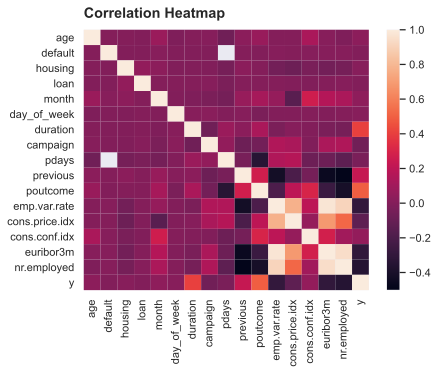

In [74]:
corr_heatmap = sns.heatmap(data=bank_mkt.corr(method="pearson")).set_title("Correlation Heatmap")

# Data Preparation and Feature Engineering

![Data Lifecycle](lifecycle.png)

## Import Dataset

We wrote a function `import_dataset()` to make sure duplicated rows, missing values, categorical and boolean data are properly processed by pandas.

In [86]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

## Partition

We need to split the dataset into trainning set and test set, then we train models on the trainning set and only use test set for final validation purposes. However, simply sampling the dataset may lead to unrepresenatative partition given that our dataset is imbalanced and clients have different features. To solve this problem, `scikit-learn` provides a useful function to select representative data as test data. We created a function `split_dataset()` to handle this process and train set splitting.

In [87]:
X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt)

## Preprocessors

We wrote a function `dftransform()` to allow us to do transformations in pandas then we use can pipelines to wrap it with other transformers. `benchmark()` is a function that utilises all the functions we wrote and output a clear performance result of our models.

In [103]:
cat_encoder = FunctionTransformer(dftransform, kw_args={"to_float":True})
cat_clf = CatBoostClassifier(eval_metric="AUC", class_weights=[1, 8])
cat_baseline = benchmark(bank_mkt, cat_encoder, cat_clf)
cat_baseline

Train  Validate      Test
TNR   0.856391  0.852378  0.858101
TPR   0.644998  0.632075  0.662716
bACC  0.750695  0.742227  0.760408
ROC   0.820901  0.804656  0.807498
REC   0.644998  0.632075  0.662716
PRE   0.363171  0.352102  0.372276
AP    0.500846  0.462837  0.472748

In [117]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome"]

num_features =  ["age",
                 "campaign",
                 "pdays",
                 "previous",
                 "emp.var.rate",
                 "cons.price.idx",
                 "cons.conf.idx",
                 "euribor3m",
                 "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

hot_transformer = make_pipeline(FunctionTransformer(dftransform), hot_scaler)
logit_clf = LogisticRegression(penalty="none", class_weight="balanced", max_iter=10000)
logit_baseline = benchmark(bank_mkt, hot_transformer, logit_clf)
logit_baseline

Train  Validate      Test
TNR   0.801993  0.811495  0.808292
TPR   0.662849  0.645553  0.682112
bACC  0.732421  0.728524  0.745202
ROC   0.786765  0.775977  0.791102
REC   0.662849  0.645553  0.682112
PRE   0.298272  0.302973  0.311209
AP    0.436517  0.450599  0.440707

## Impute Missing Values

### Use Most Frequent Values

In [105]:
freq_features = ["job", "marital", "education", "default", "housing", "loan"]

freq_imputer = ColumnTransformer([
    ("freq_imputer", SimpleImputer(missing_values=-1, strategy="most_frequent"), freq_features)
], remainder="passthrough")

freq_encoder = make_pipeline(cat_encoder, freq_imputer)
cat_freq = benchmark(bank_mkt, freq_encoder, cat_clf)
pd.concat([cat_baseline, cat_freq], keys=["Catboost Baseline", "Catboost Frequent"], axis=1)

Catboost Baseline                     Catboost Frequent            \
                 Train  Validate      Test             Train  Validate   
TNR           0.856391  0.852378  0.858101          0.844374  0.849470   
TPR           0.644998  0.632075  0.662716          0.647356  0.634771   
bACC          0.750695  0.742227  0.760408          0.745865  0.742120   
ROC           0.820901  0.804656  0.807498          0.808218  0.802463   
REC           0.644998  0.632075  0.662716          0.647356  0.634771   
PRE           0.363171  0.352102  0.372276          0.345621  0.348631   
AP            0.500846  0.462837  0.472748          0.486193  0.457619   

                
          Test  
TNR   0.848933  
TPR   0.668103  
bACC  0.758518  
ROC   0.805257  
REC   0.668103  
PRE   0.359629  
AP    0.470453

In [106]:
# Select "job", "marital", "education"
cat_features = [0,1,2]

# Select "age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"
num_features = [5,10,11,12,14,15,16,17,18]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

freq_transformer = make_pipeline(FunctionTransformer(dftransform), freq_imputer, hot_scaler)
logit_freq = benchmark(bank_mkt, freq_transformer, logit_clf)
pd.concat([logit_baseline, logit_freq], keys=["Logistic Baseline", "Logistic Frequent"], axis=1)

Logistic Baseline                     Logistic Frequent            \
                 Train  Validate      Test             Train  Validate   
TNR           0.805329  0.804482  0.808292          0.801779  0.809271   
TPR           0.658471  0.650943  0.682112          0.655103  0.654987   
bACC          0.731900  0.727713  0.745202          0.728441  0.732129   
ROC           0.787978  0.771491  0.791102          0.781756  0.790367   
REC           0.658471  0.650943  0.682112          0.655103  0.654987   
PRE           0.300446  0.297048  0.311209          0.295593  0.303560   
AP            0.444312  0.417978  0.440707          0.434254  0.459180   

                
          Test  
TNR   0.803914  
TPR   0.682112  
bACC  0.743013  
ROC   0.789962  
REC   0.682112  
PRE   0.306389  
AP    0.440133

### Estimate Missing Values 

In [107]:
ite_features = ["age", "job", "marital", "education", "default", "housing", "loan", "contact", "campaign", "month", "day_of_week", "pdays", "previous"]

ite_imputer = ColumnTransformer([
    ("ite_imputer",
     make_pipeline(
         IterativeImputer(max_iter=100, missing_values=-1, initial_strategy="most_frequent", random_state=42),
         FunctionTransformer(np.round)
     ),
     ite_features),
], remainder="passthrough")

ite_encoder = make_pipeline(cat_encoder, ite_imputer)
cat_ite = benchmark(bank_mkt, ite_encoder, cat_clf)
pd.concat([cat_baseline, cat_ite], keys=["Catboost Baseline", "Catboost Iterative"], axis=1)

Catboost Baseline                     Catboost Iterative            \
                 Train  Validate      Test              Train  Validate   
TNR           0.856391  0.852378  0.858101           0.867810  0.868457   
TPR           0.644998  0.632075  0.662716           0.673964  0.601078   
bACC          0.750695  0.742227  0.760408           0.770887  0.734768   
ROC           0.820901  0.804656  0.807498           0.865324  0.792741   
REC           0.644998  0.632075  0.662716           0.673964  0.601078   
PRE           0.363171  0.352102  0.372276           0.392969  0.367078   
AP            0.500846  0.462837  0.472748           0.549736  0.446891   

                
          Test  
TNR   0.867542  
TPR   0.653017  
bACC  0.760280  
ROC   0.809088  
REC   0.653017  
PRE   0.385006  
AP    0.471372

In [108]:
# Select "job", "marital", "education", "default", "housing", "loan", "poutcome"
cat_features = [1,2,3,4,5,13]

# Select "age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"
num_features = [0,8,9,10,12,14,15,16,17,18]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

ite_transformer = make_pipeline(FunctionTransformer(dftransform), ite_imputer, hot_scaler)
logit_ite = benchmark(bank_mkt, ite_transformer, logit_clf)
pd.concat([logit_baseline, logit_ite], keys=["Logistic Baseline", "Logistic Iterative"], axis=1)

Logistic Baseline                     Logistic Iterative            \
                 Train  Validate      Test              Train  Validate   
TNR           0.805329  0.804482  0.808292           0.793654  0.799350   
TPR           0.658471  0.650943  0.682112           0.659481  0.660377   
bACC          0.731900  0.727713  0.745202           0.726567  0.729864   
ROC           0.787978  0.771491  0.791102           0.785278  0.778975   
REC           0.658471  0.650943  0.682112           0.659481  0.660377   
PRE           0.300446  0.297048  0.311209           0.288663  0.294648   
AP            0.444312  0.417978  0.440707           0.439446  0.433095   

                
          Test  
TNR   0.802545  
TPR   0.678879  
bACC  0.740712  
ROC   0.788592  
REC   0.678879  
PRE   0.303907  
AP    0.440025

## Cut `pdays` and Generate `has_previous`

In [112]:
cut_encoder = FunctionTransformer(dftransform, kw_args={"cut": ["pdays"],
                                                        "gen": ["has_previous"],
                                                        "to_float":True})
cat_cut = benchmark(bank_mkt, cut_encoder, cat_clf)
pd.concat([cat_baseline, cat_cut], keys=["Catboost Baseline", "Catboost Cut"], axis=1)

Catboost Baseline                     Catboost Cut                    
                 Train  Validate      Test        Train  Validate      Test
TNR           0.856391  0.852378  0.858101     0.863833  0.855799  0.864122
TPR           0.644998  0.632075  0.662716     0.672954  0.609164  0.659483
bACC          0.750695  0.742227  0.760408     0.768393  0.732482  0.761802
ROC           0.820901  0.804656  0.807498     0.859052  0.783099  0.809426
REC           0.644998  0.632075  0.662716     0.672954  0.609164  0.659483
PRE           0.363171  0.352102  0.372276     0.385565  0.349035  0.381308
AP            0.500846  0.462837  0.472748     0.542866  0.448529  0.480955

In [113]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome",
                "pdays"]

num_features = ["age", "campaign", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

cut_encoder = FunctionTransformer(dftransform, kw_args={"cut": ["pdays"],
                                                        "gen": ["has_previous"]})
cut_transformer = make_pipeline(cut_encoder, hot_scaler)
logit_cut = benchmark(bank_mkt, cut_transformer, logit_clf)
pd.concat([logit_baseline, logit_cut], keys=["Logistic Baseline", "Logistic Cut"], axis=1)

Logistic Baseline                     Logistic Cut                    
                 Train  Validate      Test        Train  Validate      Test
TNR           0.805329  0.804482  0.808292     0.804987  0.801232  0.808292
TPR           0.658471  0.650943  0.682112     0.659144  0.634771  0.682112
bACC          0.731900  0.727713  0.745202     0.732066  0.718001  0.745202
ROC           0.787978  0.771491  0.791102     0.788131  0.772298  0.791128
REC           0.658471  0.650943  0.682112     0.659144  0.634771  0.682112
PRE           0.300446  0.297048  0.311209     0.300292  0.288426  0.311209
AP            0.444312  0.417978  0.440707     0.441625  0.429058  0.440483

## Generate `days` Since Financial Crisis

In [115]:
days_encoder = FunctionTransformer(dftransform, kw_args={"gen": ["days"],
                                                         "to_float":True})
cat_days = benchmark(bank_mkt, days_encoder, cat_clf)
pd.concat([cat_baseline, cat_days], keys=["Catboost Baseline", "Catboost Days"], axis=1)

Catboost Baseline                     Catboost Days                    
                 Train  Validate      Test         Train  Validate      Test
TNR           0.856391  0.852378  0.858101      0.856306  0.858536  0.860427
TPR           0.644998  0.632075  0.662716      0.646009  0.638814  0.671336
bACC          0.750695  0.742227  0.760408      0.751157  0.748675  0.765882
ROC           0.820901  0.804656  0.807498      0.828027  0.801754  0.810203
REC           0.644998  0.632075  0.662716      0.646009  0.638814  0.671336
PRE           0.363171  0.352102  0.372276      0.363395  0.364335  0.379184
AP            0.500846  0.462837  0.472748      0.507180  0.482626  0.476596

In [119]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome"]

num_features = ["age",
                "campaign",
                "previous",
                "emp.var.rate",
                "cons.price.idx",
                "cons.conf.idx",
                "euribor3m",
                "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

days_encoder = FunctionTransformer(dftransform, kw_args={"gen": ["days"]})
days_transformer = make_pipeline(days_encoder, hot_scaler)
logit_days = benchmark(bank_mkt, days_transformer, logit_clf)
pd.concat([logit_baseline, logit_days], keys=["Logistic Baseline", "Logistic Days"], axis=1)

Logistic Baseline                     Logistic Days                    
                 Train  Validate      Test         Train  Validate      Test
TNR           0.801993  0.811495  0.808292      0.815977  0.817482  0.815271
TPR           0.662849  0.645553  0.682112      0.660155  0.663073  0.684267
bACC          0.732421  0.728524  0.745202      0.738066  0.740277  0.749769
ROC           0.786765  0.775977  0.791102      0.792780  0.784390  0.794233
REC           0.662849  0.645553  0.682112      0.660155  0.663073  0.684267
PRE           0.298272  0.302973  0.311209      0.312949  0.315587  0.319899
AP            0.436517  0.450599  0.440707      0.439167  0.452470  0.441328

## Drop Features

In [99]:
drop_features = ["age",
                 "job",
                 "marital",
                 "education",
                 "housing",
                 "loan",
                 "default"]

drop_encoder = FunctionTransformer(dftransform, kw_args={"drop": drop_features,
                                                         "to_float":True})

In [100]:
cat_drop = benchmark(bank_mkt, drop_encoder, cat_clf)
pd.concat([cat_baseline, cat_drop], keys=["CatBoost Baseline", "CatBoost Drop"], axis=1)

CatBoost Baseline                     CatBoost Drop                    
                 Train  Validate      Test         Train  Validate      Test
TNR           0.859855  0.853746  0.860701      0.861096  0.855457  0.863300
TPR           0.657460  0.633423  0.660560      0.637925  0.645553  0.654095
bACC          0.758658  0.743585  0.760630      0.749510  0.750505  0.758698
ROC           0.847227  0.788328  0.807851      0.816034  0.814153  0.813974
REC           0.657460  0.633423  0.660560      0.637925  0.645553  0.654095
PRE           0.373303  0.354717  0.375843      0.368339  0.361782  0.377958
AP            0.529161  0.448530  0.474175      0.494442  0.500386  0.481997

In [101]:
cat_features = ["poutcome"]

num_features =  ["campaign",
                 "pdays",
                 "previous",
                 "emp.var.rate",
                 "cons.price.idx",
                 "cons.conf.idx",
                 "euribor3m",
                 "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

drop_encoder = FunctionTransformer(dftransform, kw_args={"drop": drop_features})

drop_transformer = make_pipeline(drop_encoder, hot_scaler)

logit_drop = benchmark(bank_mkt, drop_transformer, logit_clf)
pd.concat([logit_baseline, logit_drop], keys=["Logistic Baseline", "Logistic Drop"], axis=1)

Logistic Baseline                     Logistic Drop                    
                 Train  Validate      Test         Train  Validate      Test
TNR           0.801950  0.801232  0.808292      0.791472  0.795758  0.796251
TPR           0.656787  0.660377  0.682112      0.657124  0.657682  0.678879
bACC          0.729368  0.730804  0.745202      0.724298  0.726720  0.737565
ROC           0.783831  0.785095  0.791102      0.780372  0.776973  0.790863
REC           0.656787  0.660377  0.682112      0.657124  0.657682  0.678879
PRE           0.296308  0.296610  0.311209      0.285777  0.290131  0.297310
AP            0.441262  0.436216  0.440707      0.433720  0.431678  0.434872

# Evaluation

In [120]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [122]:
X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt,
                                                              FunctionTransformer(dftransform))

In [123]:
names = ["Constant Prediction",
         "Random Prediction",
         "K-Nearest Neighbors",
         "Linear SVM",
         "Decision Tree",
         "Logistic Regression"]

clfs = [DummyClassifier(strategy="constant", constant=1),
        DummyClassifier(strategy="uniform"),
        KNeighborsClassifier(n_neighbors=10),
        SGDClassifier(loss="hinge", class_weight="balanced"),
        DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
        LogisticRegression(class_weight="balanced")]

n = len(names)

In [124]:
y_pred = {}
for name, clf in zip(names, clfs):
    y_pred[name] = cross_val_predict(clf, X_train, y_train, cv=5, n_jobs=-1)

In [125]:
y_score = {}

y_threshold = {}

for name, clf in zip(names, clfs):
    if hasattr(clf, "decision_function"):
        response_method = "decision_function"
    else:
        response_method = "predict_proba"
        
    y_score[name] = cross_val_predict(clf,
                                      X_train,
                                      y_train,
                                      cv=5,
                                      n_jobs=-1,
                                      method=response_method)
    
    if name == "Logistic Regression":
        # For logistic regression, the hyperplane refered in the decision function is b_0+b_1x_1+...b_kx_k.
        # When hyperplane is 0, the probablity is 0.5,
        # therefore the threshold of decision function for logistic regression is 0.
        # https://stats.stackexchange.com/questions/329857/what-is-the-difference-between-decision-function-predict-proba-and-predict-fun
        y_threshold[name] = 0
    elif name == "Linear SVM":
        y_threshold[name] = 0
    else:
        y_score[name] = y_score[name][:, 1]
        y_threshold[name] = 0.5

## Confusion Matrix

The function `cross_val_predict` returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. It is not appropriate for measuring generalisation error but suited for comparing different models.

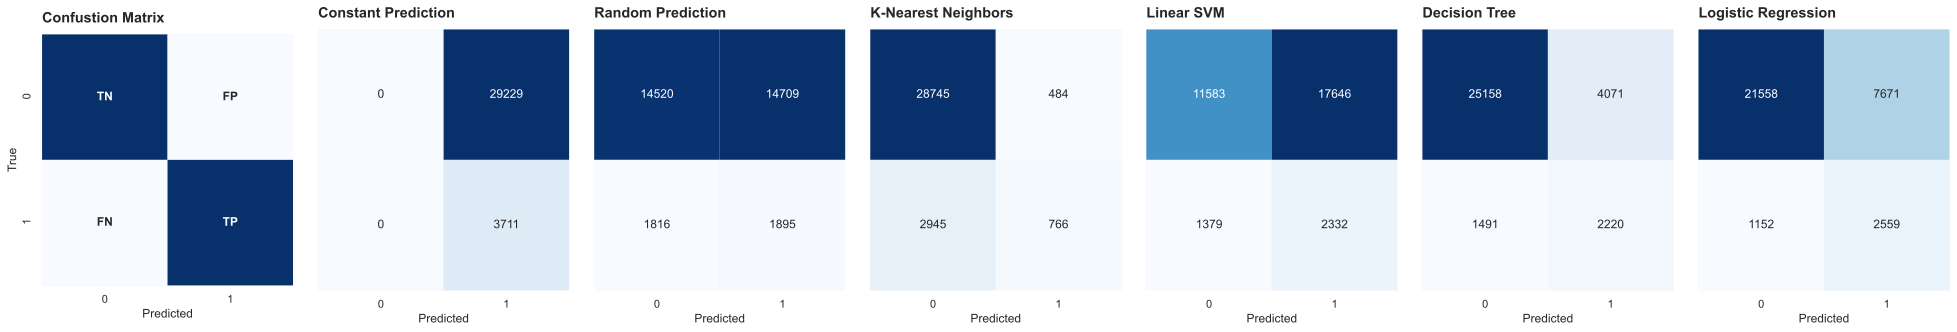

In [126]:
f, axs = plt.subplots(1, n+1, figsize=(4.8*(n+1)+0.1*n, 4.8), sharey=True, gridspec_kw=dict(wspace=0.1))

conf_mat = np.array([[100, 30], [30, 100]])
conf_label = np.array([["TN", "FP"], ["FN", "TP"]])
conf_ax = sns.heatmap(conf_mat,
                      ax=axs[0],
                      annot=conf_label,
                      annot_kws={"fontweight": "bold"},
                      fmt="",
                      square=True,
                      cmap=plt.cm.Blues, 
                      cbar=False)
conf_ax.set_xlabel("Predicted")
conf_ax.set_ylabel("True")
conf_ax.set_title("Confustion Matrix")

for i, name in zip(range(1, n+1), names):
    conf_mat = confusion_matrix(y_train, y_pred[name])
    conf_ax = sns.heatmap(conf_mat, 
                          ax=axs[i], 
                          annot=True, 
                          fmt="", 
                          cmap=plt.cm.Blues, 
                          cbar=False)
    conf_ax.set(xlabel="Predicted", title=name)

## Performance Matrics

From the Confusion Matrix, we can deride some key performance metrics. The false positive rate (FPR) measures the error rate of the negative outcomes:

$$
FPR = \frac{FP}{N} = \frac{FP}{FP+TN}
$$

The true negative rate (TNR) measures the accuracy rate for the negative outcomes:

$$
TNR = \frac{TP}{N} = \frac{TN}{TN+FP} = 1 - FPR
$$

The true positive rate (TPR) measures the accuracy rate for the positive outcomes:

$$
TPR = \frac{TP}{P} = \frac{TP}{TP+FN}
$$

Balanced accuracy is the average of true positive rate and true negative rate:

$$
bACC = \frac{TPR+TNR}{2}
$$

True positive rate is also known as recall (REC):

$$
REC = TPR = \frac{TP}{TP+FN}
$$

Precision (PRE) measures the accuracy of the predicted positive outcomes:

$$
PRE = \frac{TP}{TP+FP}
$$

To balance the up- and down-sides of optimizing PRE and REC, the harmonic mean of precision and recall is used:

$$
F_1 = 2 \cdot \frac{PRE \times REC}{PRE + REC}
$$

In [127]:
matric_names = ["FPR", "TNR", "TPR", "bACC", "REC", "PRE", "F1"]
matric_df = pd.DataFrame(index=matric_names, columns=names)

for name, clf in zip(names, clfs):
    matrics = [1-recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name]),
               balanced_accuracy_score(y_train, y_pred[name]),
               recall_score(y_train, y_pred[name]),
               precision_score(y_train, y_pred[name]),
               f1_score(y_train, y_pred[name])]
    matric_df[name] = matrics

matric_df

Constant Prediction  Random Prediction  K-Nearest Neighbors  Linear SVM  \
FPR              1.000000           0.503233             0.016559    0.603715   
TNR              0.000000           0.496767             0.983441    0.396285   
TPR              1.000000           0.510644             0.206413    0.628402   
bACC             0.500000           0.503705             0.594927    0.512343   
REC              1.000000           0.510644             0.206413    0.628402   
PRE              0.112659           0.114129             0.612800    0.116728   
F1               0.202505           0.186562             0.308809    0.196885   

      Decision Tree  Logistic Regression  
FPR        0.139279             0.262445  
TNR        0.860721             0.737555  
TPR        0.598222             0.689572  
bACC       0.729471             0.713563  
REC        0.598222             0.689572  
PRE        0.352885             0.250147  
F1         0.443911             0.367119

## Receiver Operating Characteristic

A receiver operating characteristic (ROC) is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting TPR against FPR at various threshold settings.

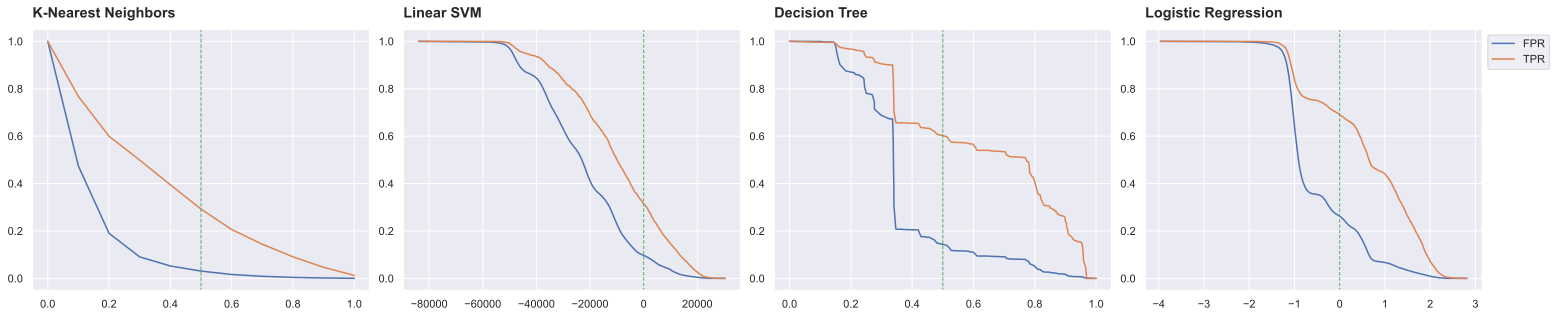

In [128]:
f, axs = plt.subplots(1, n-2, figsize=(6.4*(n-2)+0.1*(n-2), 4.8), gridspec_kw=dict(wspace=0.1))

for i, name in zip(range((n-2)), names[2:]):
    fprs, tprs, thresholds = roc_curve(y_train, y_score[name])
    roc_df = pd.DataFrame({"FPR": fprs[1:], "TPR": tprs[1:]}, index=thresholds[1:])
    ax = roc_df.plot.line(ax=axs[i], ylim=(-0.05,1.05), legend=False, title=name)
    
    threshold = y_threshold[name]
    ax.plot((threshold, threshold), (-2,2),  linestyle="--", linewidth=1)
    
#     tnrs = 1 - fprs
#     ax.plot(thresholds[1:], tnrs[1:], color="k", label="TNR")
    
    if i == n-3:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

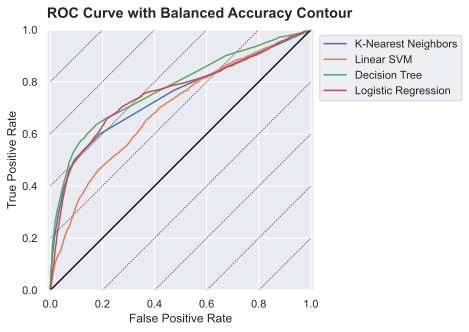

In [129]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def bacc(x, y):
    return (1-x+y)/2

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x, y)
Z = bacc(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    fpr, tpr, thresholds = roc_curve(y_train, y_score[name])
    ax.plot(fpr, tpr, label=name)
    
ax.plot([0, 1], [0, 1], color="k")
ax.axis("equal")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set(xlabel="False Positive Rate",
       ylabel="True Positive Rate",
       title="ROC Curve with Balanced Accuracy Contour");

## Precision-Recall Curve

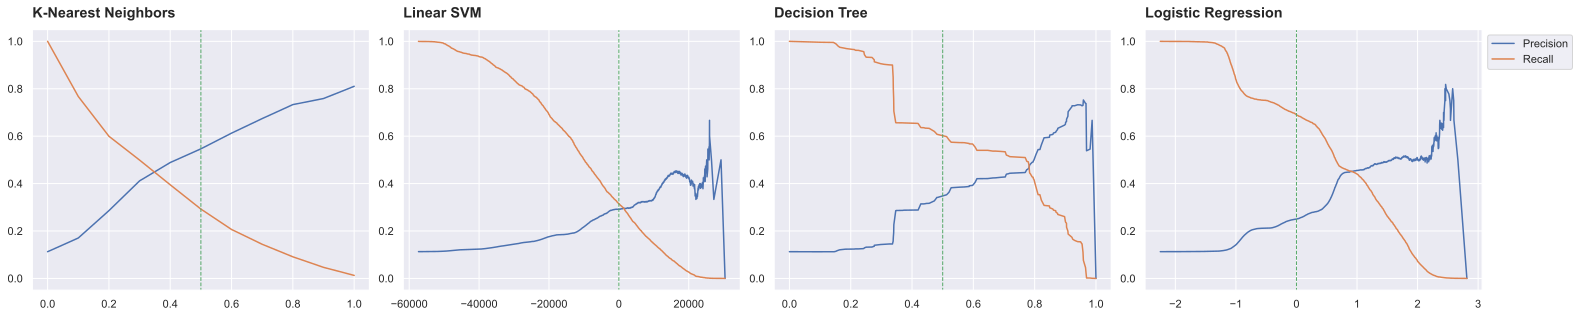

In [130]:
f, axs = plt.subplots(1, n-2, figsize=(6.4*(n-2)+0.1*(n-2), 4.8), gridspec_kw=dict(wspace=0.1))

for i, name in zip(range((n-2)), names[2:]):
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precision_recall_df = pd.DataFrame({"Precision": precisions[:-1], "Recall": recalls[:-1]}, index=thresholds)
    ax = precision_recall_df.plot.line(ax=axs[i], ylim=(-0.05,1.05), legend=False, title=name)
    
    threshold = y_threshold[name]
    ax.plot((threshold, threshold), (-2,2),  linestyle="--", linewidth=1)
    
    if i == n-3:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

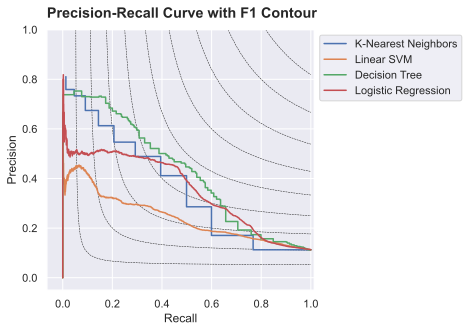

In [131]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def f1(x, y):
    return 2*x*y/(x+y)

x = np.linspace(0.01,1)
y = np.linspace(0.01,1)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    ax.plot(recalls, precisions, drawstyle="steps-post", label=name)

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axis("equal")
ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="Recall", ylabel="Precision", title="Precision-Recall Curve with F1 Contour")

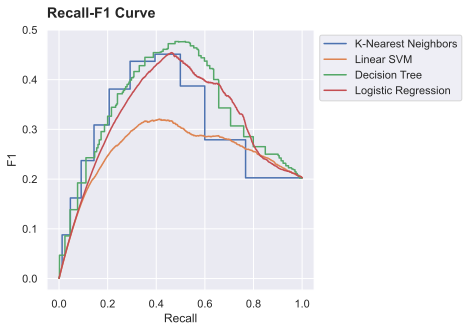

In [135]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))
for name in names[2:]:
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    ax.plot(recalls, 2*recalls*precisions/(recalls+precisions), drawstyle="steps-post", label=name)
ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="Recall", ylabel="F1", title="Recall-F1 Curve")

Average precision (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

$$
AP = \sum_{n} (REC_n - REC_{n-1})PRE_n
$$

In [133]:
matric_names = ["FPR", "TNR", "TPR", "bACC", "ROC", "REC", "PRE", "F1", "AP"]
matric_df = pd.DataFrame(index=matric_names, columns=names)

for name, clf in zip(names, clfs):
    matrics = [1-recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name]),
               balanced_accuracy_score(y_train, y_pred[name]),
               roc_auc_score(y_train, y_score[name]),
               recall_score(y_train, y_pred[name]),
               precision_score(y_train, y_pred[name]),
               f1_score(y_train, y_pred[name]),
               average_precision_score(y_train, y_score[name])]
    matric_df[name] = matrics

matric_df

Constant Prediction  Random Prediction  K-Nearest Neighbors  Linear SVM  \
FPR              1.000000           0.503233             0.016559    0.603715   
TNR              0.000000           0.496767             0.983441    0.396285   
TPR              1.000000           0.510644             0.206413    0.628402   
bACC             0.500000           0.503705             0.594927    0.512343   
ROC              0.500000           0.500000             0.743644    0.691270   
REC              1.000000           0.510644             0.206413    0.628402   
PRE              0.112659           0.114129             0.612800    0.116728   
F1               0.202505           0.186562             0.308809    0.196885   
AP               0.112659           0.112659             0.366046    0.242110   

      Decision Tree  Logistic Regression  
FPR        0.139279             0.262445  
TNR        0.860721             0.737555  
TPR        0.598222             0.689572  
bACC       0.729471             0.713563  
ROC        0.776519             0.754306  
REC        0.598222             0.689572  
PRE        0.352885             0.250147  
F1         0.443911             0.367119  
AP         0.425635             0.353014

# Logistic Regression

In [169]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [170]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome"]

num_features =  ["age",
                 "campaign",
                 "pdays",
                 "previous",
                 "emp.var.rate",
                 "cons.price.idx",
                 "cons.conf.idx",
                 "euribor3m",
                 "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

hot_transformer = make_pipeline(FunctionTransformer(dftransform), hot_scaler)

X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt, hot_transformer)

In [ ]:
lrmodel = LogisticRegression(class_weight='balanced',max_iter=10000) 
lrmodel.fit(X_train, y_train)
y_train_pred = lrmodel.predict(X_train)
#### model measures for training data
cmtr = confusion_matrix(y_train, y_train_pred)
acctr = accuracy_score(y_train, y_train_pred)
aps_train = average_precision_score(y_train, y_train_pred)

#### fit test set data
lrmodel.fit(X_test, y_test)
y_test_pred = lrmodel.predict(X_test)
#### model measures for testing data
cmte = confusion_matrix(y_test, y_test_pred)
accte = accuracy_score(y_test, y_test_pred)
aps_test = average_precision_score(y_test, y_test_pred)

print('Accuracy Score:',acctr, '    APS:',aps_train)
print('Accuracy Score:',accte, '    APS:',aps_test)

In [159]:
benchmark(bank_mkt, hot_transformer, lrmodel)

Train  Validate      Test
TNR   0.798016  0.806363  0.808155
TPR   0.658808  0.664420  0.682112
bACC  0.728412  0.735392  0.745134
ROC   0.782488  0.793452  0.791122
REC   0.658808  0.664420  0.682112
PRE   0.292858  0.303385  0.311057
AP    0.432144  0.468702  0.441132

## Grid Search 


In [162]:
#### Try the 1st GridSearch param_grid combination:
lrmodel = LogisticRegression(class_weight='balanced', max_iter=10000)

#### Grid Search
param_grid = {'penalty': ['l2'],
              'C':[0.001,.009,0.01,.09,1,5,10,25,50,100]}
GS_lrmodel_1 = GridSearchCV(lrmodel, param_grid, scoring='recall')
GS_lrmodel_1.fit(X_train, y_train)
lrmodel_gs1 = lrmodel.set_params(**GS_lrmodel_1.best_params_)

#### use calibrated model on train set
lrmodel_gs1.fit(X_train, y_train)
y_train_pred = lrmodel_gs1.predict(X_train)
cmtr_gs1 = confusion_matrix(y_train, y_train_pred)
acctr_gs1 = accuracy_score(y_train, y_train_pred)
aps_train_gs1 = average_precision_score(y_train, y_train_pred)

#### test the model
lrmodel_gs1.fit(X_test, y_test)
y_test_pred = lrmodel_gs1.predict(X_test)
cmte_gs1 = confusion_matrix(y_test, y_test_pred)
accte_gs1 = accuracy_score(y_test, y_test_pred)
aps_test_gs1 = average_precision_score(y_test, y_test_pred)

print('Confusion Matrix:\n',cmtr_gs1,'\nAccuracy Score:\n',acctr_gs1, '\nAPS:\n',aps_train_gs1)
print('Confusion Matrix:\n',cmte_gs1,'\nAccuracy Score:\n',accte_gs1, '\nAPS:\n',aps_test_gs1)
print('best parameters:',GS_lrmodel_1.best_params_)

Confusion Matrix:
 [[22114  7115]
 [ 1157  2554]] 
Accuracy Score:
 0.7488767455980571 
APS:
 0.2169141680311616
Confusion Matrix:
 [[5317 1991]
 [ 250  678]] 
Accuracy Score:
 0.7279018941233608 
APS:
 0.21594807342264202
best parameters: {'C': 0.001, 'penalty': 'l2'}


In [163]:
benchmark(bank_mkt, hot_transformer, lrmodel_gs1)

Train  Validate      Test
TNR   0.773767  0.778823  0.778462
TPR   0.670259  0.671159  0.703664
bACC  0.722013  0.724991  0.741063
ROC   0.760916  0.766017  0.778983
REC   0.670259  0.671159  0.703664
PRE   0.273352  0.278057  0.287412
AP    0.390029  0.409618  0.421699

In [164]:
#### Try the 2nd GridSearch param_grid combination:
lrmodel_gs = LogisticRegression(class_weight='balanced',max_iter=10000)

#### Grid Search
param_grid = {"C":np.logspace(-2,2,7), 
              "penalty":["l1","l2"],
              "solver": ["saga"]}
GS_lrmodel_2 = GridSearchCV(lrmodel_gs, param_grid, cv=10)
GS_lrmodel_2.fit(X_train, y_train)
lrmodel_gs2 = lrmodel_gs.set_params(**GS_lrmodel_2.best_params_)

#### use calibrated model on train set
lrmodel_gs2.fit(X_train, y_train)
y_train_pred = lrmodel_gs2.predict(X_train)
cmtr_gs2 = confusion_matrix(y_train, y_train_pred)
acctr_gs2 = accuracy_score(y_train, y_train_pred)
aps_train_gs2 = average_precision_score(y_train, y_train_pred)
#### test the model
lrmodel_gs2.fit(X_test, y_test)
y_test_pred = lrmodel_gs2.predict(X_test)
cmte_gs2 = confusion_matrix(y_test, y_test_pred)
accte_gs2 = accuracy_score(y_test, y_test_pred)
aps_test_gs2 = average_precision_score(y_test, y_test_pred)

print('Confusion Matrix:\n',cmtr_gs2,'\nAccuracy Score:\n',acctr_gs2, '\nAPS:\n',aps_train_gs2)
print('Confusion Matrix:\n',cmte_gs2,'\nAccuracy Score:\n',accte_gs2, '\nAPS:\n',aps_test_gs2)
print('best parameters:',GS_lrmodel_2.best_params_)

Confusion Matrix:
 [[23501  5728]
 [ 1273  2438]] 
Accuracy Score:
 0.7874620522161506 
APS:
 0.2347864302907522
Confusion Matrix:
 [[5891 1417]
 [ 294  634]] 
Accuracy Score:
 0.7922535211267606 
APS:
 0.24688282099327752
best parameters: {'C': 100.0, 'penalty': 'l1', 'solver': 'saga'}


In [165]:
benchmark(bank_mkt, hot_transformer, lrmodel_gs2)

Train  Validate      Test
TNR   0.806740  0.805679  0.808429
TPR   0.653419  0.667116  0.682112
bACC  0.730079  0.736397  0.745271
ROC   0.780145  0.795063  0.791111
REC   0.653419  0.667116  0.682112
PRE   0.300356  0.303495  0.311363
AP    0.445394  0.419520  0.440677

## Statistical Properties

In [185]:
bank_transform = dftransform(bank_mkt)
X = bank_transform.drop("y", axis=1).astype("float")
X_encode = hot_scaler.fit_transform(X)
y = bank_transform["y"].astype("int").to_numpy()
logit_model = sm.Logit(y, X_encode)
result = logit_model.fit(maxiter=10000)
print(result.summary())

         Current function value: 0.214947
         Iterations: 10000
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41176
Model:                          Logit   Df Residuals:                    41135
Method:                           MLE   Df Model:                           40
Date:                Thu, 12 Nov 2020   Pseudo R-squ.:                  0.3894
Time:                        01:20:31   Log-Likelihood:                -8850.7
converged:                      False   LL-Null:                       -14496.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7785      0.182     -4.270      0.000      -1.136      -0.421
x2            -1.1103      0.185     -6.004      0.000      -1

/usr/local/Caskroom/miniconda/base/envs/analytics/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# SVM

In [144]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [147]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome"]

num_features =  ["age",
                 "campaign",
                 "pdays",
                 "previous",
                 "emp.var.rate",
                 "cons.price.idx",
                 "cons.conf.idx",
                 "euribor3m",
                 "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

hot_transformer = make_pipeline(FunctionTransformer(dftransform), hot_scaler)

X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt, hot_transformer)

## Linear SVM

In [ ]:
linear_svm = LinearSVC(dual=False, class_weight="balanced", random_state=42)

In [ ]:
param_distributions = {"loss": ["squared_hinge", "hinge"],
                       "C": loguniform(1e0, 1e3)}

random_search = RandomizedSearchCV(linear_svm,
                                   param_distributions,
                                   scoring="average_precision",
                                   cv=5,
                                   n_jobs=-1,
                                   n_iter=100)

grid_fit = random_search.fit(X_train, y_train)
grid_results = random_search.cv_results_
grid_best_params = random_search.best_params_
grid_best_score = random_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'C': 2.2805604370846098, 'loss': 'squared_hinge'}, with mean test score: 0.4329862719989707


In [ ]:
param_grid = [
    {"C": [5,2,1]}
    ]
grid_search = GridSearchCV(linear_svm,
                           param_grid,
                           scoring="average_precision",
                           return_train_score=True,
                           cv=5,
                           n_jobs=-1)

grid_fit = grid_search.fit(X_train, y_train)
grid_results = grid_search.cv_results_
grid_best_params = grid_search.best_params_
grid_best_score = grid_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'C': 1}, with mean test score: 0.4119208100466861


In [ ]:
linear_svm = LinearSVC(loss="squared_hinge", C=1, dual=False, class_weight="balanced", random_state=42)
benchmark(bank_mkt, hot_transformer, linear_svm)

Train  Validation      Test
ACC   0.767911    0.768033  0.768334
bACC  0.726422    0.726259  0.727875
ROC   0.781397    0.780210  0.782012
REC   0.672865    0.672334  0.675647
PRE   0.279885    0.279757  0.280662
F1    0.395235    0.395091  0.396584
AP    0.413407    0.411920  0.418599

## Non-Linear SVM

The Nystroem method, as implemented in Nystroem is a general method for low-rank approximations of kernels. It achieves this by essentially subsampling the data on which the kernel is evaluated.

In [ ]:
rbf_sgd_clf = Pipeline([
    ("rbf", RBFSampler(random_state=42)),
    ("svm", SGDClassifier(class_weight="balanced"))
])

In [ ]:
param_distributions = {
    "rbf__gamma": loguniform(1e-6, 1e-3),
    "svm__alpha": loguniform(1e-10, 1e-6)}

random_search = RandomizedSearchCV(rbf_sgd_clf,
                                   param_distributions,
                                   scoring="average_precision",
                                   cv=5,
                                   n_jobs=-1,
                                   n_iter=10)

grid_fit = random_search.fit(X_train, y_train)
grid_results = random_search.cv_results_
grid_best_params = random_search.best_params_
grid_best_score = random_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'rbf__gamma': 0.0009558911069941637, 'svm__alpha': 4.051869841853733e-09}, with mean test score: 0.43036481588988706


In [ ]:
param_grid = {
    "rbf__gamma": [0.0008, 0.0001, 0.001],
    "svm__alpha": [1e-7, 1e-6, 1e-5]}

grid_search = GridSearchCV(rbf_sgd_clf,
                           param_grid,
                           scoring="average_precision",
                           cv=5,
                           n_jobs=-1)

grid_fit = grid_search.fit(X_train, y_train)
grid_results = grid_search.cv_results_
grid_best_params = grid_search.best_params_
grid_best_score = grid_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'rbf__gamma': 0.0008, 'svm__alpha': 1e-06}, with mean test score: 0.4324409893062057


In [ ]:
rbf_sgd_tuned = rbf_sgd_clf.set_params(rbf__gamma=0.0009, svm__alpha=1e-6)
benchmark(bank_mkt, hot_transformer, rbf_sgd_tuned)

Train  Validation      Test
ACC   0.717942    0.718610  0.572972
bACC  0.706910    0.707587  0.682702
ROC   0.787956    0.786174  0.787414
REC   0.692670    0.693355  0.824353
PRE   0.293044    0.295491  0.185725
F1    0.393744    0.395730  0.303150
AP    0.434834    0.434019  0.430296

In [ ]:
rbf_clf = Pipeline([
    ("rbf", RBFSampler(random_state=42)),
    ("svm", LinearSVC(loss="squared_hinge", dual=False, class_weight="balanced", max_iter=1000))
])

In [ ]:
param_distributions = {
    "rbf__gamma": loguniform(1e-6, 1e-3),
    "svm__C": loguniform(1e-1, 1e1)}

random_search = RandomizedSearchCV(rbf_clf,
                                   param_distributions,
                                   scoring="average_precision",
                                   cv=5,
                                   n_jobs=-1,
                                   n_iter=10)

grid_fit = random_search.fit(X_train, y_train)
grid_results = random_search.cv_results_
grid_best_params = random_search.best_params_
grid_best_score = random_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'rbf__gamma': 7.577656549962983e-05, 'svm__C': 2.866049325364455}, with mean test score: 0.4184970508015223


In [ ]:
param_grid = {
    "rbf__gamma": [0.0001, 0.001, 0.01],
    "svm__C": [1, 10, 20]}

grid_search = GridSearchCV(rbf_clf,
                           param_grid,
                           scoring="average_precision",
                           cv=5,
                           n_jobs=-1)

grid_fit = grid_search.fit(X_train, y_train)
grid_results = grid_search.cv_results_
grid_best_params = grid_search.best_params_
grid_best_score = grid_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'rbf__gamma': 0.001, 'svm__C': 20}, with mean test score: 0.43551790941021673


In [ ]:
rbf_tuned = rbf_clf.set_params(rbf__gamma=0.0009, svm__C=1)
benchmark(bank_mkt, hot_transformer, rbf_tuned)

Train  Validation      Test
ACC   0.765634    0.765786  0.771734
bACC  0.728932    0.728639  0.733084
ROC   0.784913    0.783210  0.783101
REC   0.681555    0.680685  0.683190
PRE   0.278976    0.278960  0.285586
F1    0.395884    0.395717  0.402795
AP    0.433833    0.431180  0.433370

# Neural Network

In [144]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [147]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome"]

num_features =  ["age",
                 "campaign",
                 "pdays",
                 "previous",
                 "emp.var.rate",
                 "cons.price.idx",
                 "cons.conf.idx",
                 "euribor3m",
                 "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

hot_transformer = make_pipeline(FunctionTransformer(dftransform), hot_scaler)

X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt, hot_transformer)

In [ ]:
mlp=MLPClassifier(solver ="lbfgs",random_state=42,max_iter=1000)
benchmark(bank_mkt, hot_transformer, mlp)

Train  Validate      Test
TNR   0.990591  0.990250  0.986180
TPR   0.188953  0.192722  0.181034
bACC  0.589772  0.591486  0.583607
ROC   0.758686  0.785037  0.770525
REC   0.188953  0.192722  0.181034
PRE   0.718310  0.715000  0.624535
AP    0.419627  0.436628  0.410457

# Grid Search

In [ ]:
mlp=MLPClassifier(random_state=42,max_iter=1000)

param_grid ={
    'solver':['lbfgs', 'sgd', 'adam'],
    'learning_rate':["constant","invscaling","adaptive"],
    'hidden_layer_sizes':[(100,),(200,),(20,5,),(10,5,),(100,50,25,)],
    'alpha':[0.0,0.001,0.01],
    'activation' :["logistic","relu","tanh"] }

grid_search = GridSearchCV(estimator=mlp,
                          param_grid=param_grid,
                          scoring = "average_precision",
                          return_train_score=True,
                          cv =2,
                          n_jobs=-1) 
       
grid_fit = grid_search.fit(X_train, y_train)
grid_results = grid_search.cv_results_
grid_best_params = grid_search.best_params_
grid_best_score = grid_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}, with mean test score: 0.4208468058986027


In [ ]:
mlp_trained=MLPClassifier(solver ="lbfgs",
                          random_state=42,
                          max_iter=1000,
                          activation = 'relu',
                          alpha = 0.01,
                          hidden_layer_sizes = (100,),
                          learning_rate = 'constant')

benchmark(bank_mkt, hot_transformer, mlp_trained)

Train  Validate      Test
TNR   0.989308  0.989052  0.986590
TPR   0.196362  0.212938  0.193966
bACC  0.592835  0.600995  0.590278
ROC   0.767806  0.766741  0.771836
REC   0.196362  0.212938  0.193966
PRE   0.699880  0.711712  0.647482
AP    0.428753  0.432484  0.415162

# Decision Tree and Its Ensembles

In [144]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [147]:
tree_transformer = FunctionTransformer(dftransform)
X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt, tree_transformer)

In [19]:
RF = RandomForestClassifier(random_state=42,class_weight="balanced",criterion ="gini",max_features="auto", 
                           min_samples_split= 2)

param_grid = {
    'max_depth':[6,8,10],
    'n_estimators':[1000,1500,1750,2000]
}
CV_RFmodel = GridSearchCV(estimator=RF,param_grid=param_grid,scoring="average_precision",n_jobs=-1,cv=2)
CV_RFmodel.fit(X_train,y_train)
grid_results = CV_RFmodel.cv_results_
grid_best_params = CV_RFmodel.best_params_
grid_best_score = CV_RFmodel.best_score_
grid_best_estimator = CV_RFmodel.best_estimator_
print(f"best mean test score: {grid_best_score}, for {grid_best_estimator}")

best mean test score: 0.46101896083896854, for RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=1500,
                       random_state=42)


In [8]:
RF_validation = RandomForestClassifier(random_state=42,class_weight="balanced",max_depth=6,n_estimators=1500,
                                       max_leaf_nodes=1000)
benchmark(bank_mkt, tree_transformer, RF_validation)

Train  Validation      Test
TNR   0.870305    0.865035  0.872448
TPR   0.626801    0.634595  0.592119
bACC  0.748553    0.749815  0.732284
ROC   0.818259    0.795774  0.790840
REC   0.626801    0.634595  0.592119
PRE   0.379498    0.372935  0.373907
F1    0.472762    0.469788  0.458368
AP    0.512891    0.447884  0.458924

In [9]:
columns = bank_mkt.drop(["duration", "y"], axis=1).columns.tolist()
rnd_clf = RandomForestClassifier(n_estimators=1750,max_depth=6, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
for name, importance in zip(columns, rnd_clf.feature_importances_):
    print(name, "=", importance)

age = 0.005318709730052927
job = 0.0032283459419663466
marital = 1.962391531748617e-08
education = 0.0016923784556616664
default = 0.0015466224826179954
housing = 0.023405619636046142
loan = 0.005891481331971973
contact = 0.017745324139464388
month = 0.030886343397778574
day_of_week = 0.009189907732605933
campaign = 0.00815846429064134
pdays = 0.03797015147062547
previous = 0.023062423051796697
poutcome = 0.1397408073745672
emp.var.rate = 0.08445578032649204
cons.price.idx = 0.06038263945526357
cons.conf.idx = 0.08315426812165776
euribor3m = 0.2190410622256826
nr.employed = 0.24512965121119204


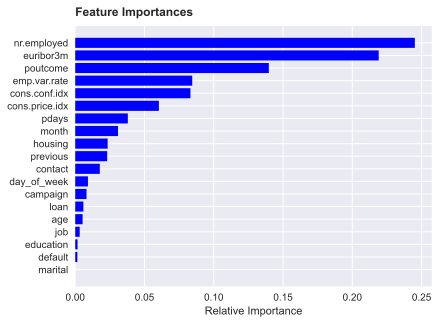

In [10]:
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig("Feature importance.png")
plt.size=(15,10)
plt.show()

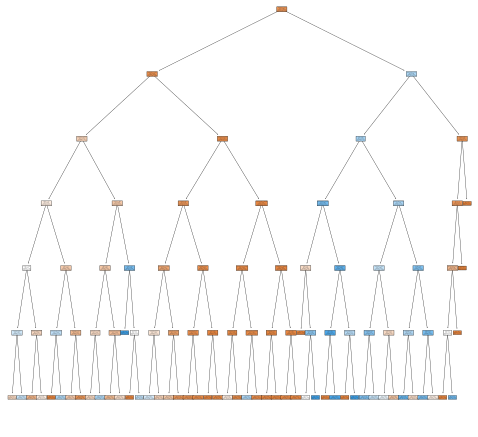

In [11]:
fn= columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=300)
tree.plot_tree(rnd_clf.estimators_[0],
               feature_names = fn,
               filled = True,
              proportion=True);
fig.savefig('rf_individualtree.png')

In [13]:
AB= AdaBoostClassifier(n_estimators=100,random_state=42,learning_rate=1.0)

param_grid = {
    'learning_rate':[0.8],
    'n_estimators':[800],
    'base_estimator':[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=4)]
}
CV_RFmodel = GridSearchCV(estimator=AB,param_grid=param_grid,scoring="average_precision",n_jobs=-1,cv=2)
CV_RFmodel.fit(X_train,y_train)
grid_results = CV_RFmodel.cv_results_
grid_best_params = CV_RFmodel.best_params_
grid_best_score = CV_RFmodel.best_score_
grid_best_estimator = CV_RFmodel.best_estimator_
print(f"best mean test score: {grid_best_score}, for {grid_best_estimator}")

best mean test score: 0.45322103045583806, for AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.8, n_estimators=800, random_state=42)


In [16]:
AB_validation = AdaBoostClassifier(n_estimators=800,learning_rate=0.8,random_state=42,
                                       base_estimator = DecisionTreeClassifier(max_depth=2,min_samples_split=2))

benchmark(bank_mkt, tree_transformer, AB_validation)

Train  Validation      Test
TNR   0.985982    0.972650  0.979312
TPR   0.393448    0.262162  0.272630
bACC  0.689715    0.617406  0.625971
ROC   0.878366    0.743267  0.757640
REC   0.393448    0.262162  0.272630
PRE   0.780308    0.548023  0.628993
F1    0.523125    0.354662  0.380386
AP    0.632423    0.374018  0.423666

In [15]:
columns = bank_mkt.drop(["duration", "y"], axis=1).columns.tolist()
AB_influence = AdaBoostClassifier(n_estimators=800,learning_rate=0.8,random_state=42)
for name, importance in zip(columns, AB_influence.feature_importances_):
    print(name, "=", importance)

age = 0.005318709730052927
job = 0.0032283459419663466
marital = 1.962391531748617e-08
education = 0.0016923784556616664
default = 0.0015466224826179954
housing = 0.023405619636046142
loan = 0.005891481331971973
contact = 0.017745324139464388
month = 0.030886343397778574
day_of_week = 0.009189907732605933
campaign = 0.00815846429064134
pdays = 0.03797015147062547
previous = 0.023062423051796697
poutcome = 0.1397408073745672
emp.var.rate = 0.08445578032649204
cons.price.idx = 0.06038263945526357
cons.conf.idx = 0.08315426812165776
euribor3m = 0.2190410622256826
nr.employed = 0.24512965121119204


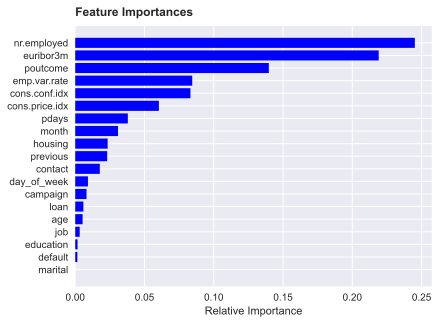

In [17]:
importances = AB_influence.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig("Feature importance.png")
plt.size=(15,10)
plt.savefig("Feature importance_ada.png")
plt.show()

# Ensemble Method

In [187]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [190]:
cat_clf = make_pipeline(FunctionTransformer(dftransform, kw_args={"to_float":True}),
                        CatBoostClassifier(eval_metric="AUC", class_weights=[1, 8], verbose=False))

benchmark(bank_mkt, None, cat_clf)

Train  Validate      Test
TNR   0.878758  0.861786  0.869048
TPR   0.777029  0.626685  0.641164
bACC  0.827894  0.744235  0.755106
ROC   0.919899  0.793252  0.802148
REC   0.777029  0.626685  0.641164
PRE   0.448658  0.365279  0.383376
AP    0.651540  0.445150  0.480899

In [192]:
drop_features = ["age",
                 "job",
                 "marital",
                 "education",
                 "housing",
                 "loan",
                 "default"]

xgb_clf = make_pipeline(FunctionTransformer(dftransform, kw_args= {"drop": drop_features,
                                                                     "gen": ["days",
                                                                             "has_previous",
                                                                             "has_default",
                                                                             "has_marital"],
                                                                     "to_float":True}),
                        XGBClassifier(max_depth=3, gamma=1, min_child_weight=1, scale_pos_weight=8))

benchmark(bank_mkt, None, xgb_clf)

Train  Validate      Test
TNR   0.858957  0.858536  0.858238
TPR   0.662176  0.622642  0.660560
bACC  0.760567  0.740589  0.759399
ROC   0.826547  0.797966  0.815077
REC   0.662176  0.622642  0.660560
PRE   0.373480  0.358417  0.371740
AP    0.517761  0.476887  0.488555

In [128]:
voting_clf = VotingClassifier(
    estimators=[("cat", cat_clf),
                ("xgb", xgb_clf)],
    voting="soft",
    n_jobs=-1)
benchmark(bank_mkt, None, voting_clf)

Train  Validate      Test
TNR   0.919642  0.908827  0.907909
TPR   0.600202  0.557951  0.572198
bACC  0.759922  0.733389  0.740054
ROC   0.880880  0.802681  0.800868
REC   0.600202  0.557951  0.572198
PRE   0.486752  0.437170  0.441030
AP    0.580858  0.430137  0.444582

In [193]:
stacking_clf = StackingClassifier(
    estimators=[("cat", cat_clf),
                ("xgb", xgb_clf)],
    n_jobs=-1)
benchmark(bank_mkt, None, stacking_clf)

Train  Validate      Test
TNR   0.985716  0.979473  0.981390
TPR   0.315594  0.291105  0.264009
bACC  0.650655  0.635289  0.622699
ROC   0.869835  0.798240  0.813999
REC   0.315594  0.291105  0.264009
PRE   0.737215  0.642857  0.643045
AP    0.565360  0.462469  0.489860

# Summary of Modelling

In [40]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [40]:
bank_mkt.loc[bank_mkt.index < 27682, "year"] = 2008
bank_mkt.loc[(27682<=bank_mkt.index) & (bank_mkt.index<39118), "year"] = 2009
bank_mkt.loc[39118<=bank_mkt.index, "year"] = 2010
bank_mkt["year"] = bank_mkt["year"].astype("int")
bank_transform = dftransform(bank_mkt, fillna=False, to_numpy=True)
X = bank_transform.drop(["duration", "y"], axis=1)
y = bank_transform["y"]
xgb_clf = XGBClassifier(max_depth=3, scale_pos_weight=8)
bank_mkt["y_pred"] = cross_val_predict(xgb_clf, X, y)

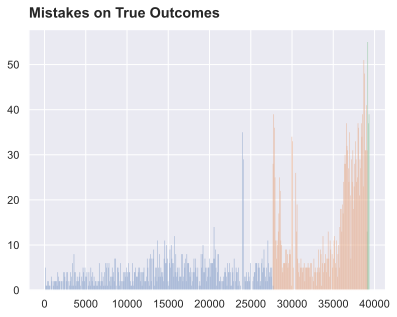

In [40]:
mistake = bank_mkt[(bank_mkt.y == True) & (bank_mkt.y_pred == False)].reset_index()
ax = sns.histplot(data=mistake, x="index", stat="count", hue="year", bins=500, legend=False)
ax.set(xlabel="", ylabel="", title="Mistakes on True Outcomes");